# Ensemble 
- lstm,cnn을 boost알고리즘과 앙상블하려면, 1. 부스팅알고리즘만 사용하던가, 2. 스태킹앙상블하던가 

- 평가차트를보면 실제주가데이터보다 살짝 이틀?정도 밀려서 예측을하는데, 그럼 스태킹앙상블해서 캣부스트로 넣으면 이를 어느정도 보완해서 정확히 예측할수있지않을까?
- 예를들면 이런거지. 실제주가데이터가 4,3,2,3,5,7순서라면, lstm,cnn은 4,4,3,2,2,3,5,8이런식으로 한발짝 늦게가니까, 이러한 패턴을 스태킹앙상블 캣부스트가 잡아주지않을까?

In [59]:
# GPU Check
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        print("Name:", gpu.name, "Type:", gpu.device_type)
        print("Num GPUs Available: ", len(gpus))

Name: /physical_device:GPU:0 Type: GPU
Num GPUs Available:  1


## 데이터셋 정규화/전처리

In [46]:
import yfinance
import numpy as np
import tensorflow as tf
import os

# Original datasetb
df = yfinance.download('AAPL','2000-1-1','2020-1-1')
df = df.drop(['Volume'],1).drop(['Adj Close'],1)
display(df)

# 정규화 0~1
def normalize_data(dataset):
    cols = dataset.columns.tolist()
    # 편의상 모든컬럼명을 인덱스(실수)로 바꿈
    col_name = [0]*len(cols)          # [0, 0, 0, 0]
    for i in range(len(cols)):
        col_name[i] = i               # [0, 1, 2, 3]
    dataset.columns = col_name
    dtypes = dataset.dtypes.tolist()
    minmax = list()
    for column in dataset:
        dataset = dataset.astype({column: 'float32'})
    # 각 컬럼의 min, max 저장(정규화를 위함)
    for i in range(len(cols)):
        col_values = dataset[col_name[i]]
        value_min = min(col_values)
        value_max = max(col_values)
        minmax.append([value_min, value_max])
    # 0~1사이값으로 정규화
    for column in dataset:
        values = dataset[column].values
        for i in range(len(values)):
            values[i] = (values[i] - minmax[column][0]) / (minmax[column][1] - minmax[column][0])
        dataset[column] = values
    dataset[column] = values
    return dataset,minmax
    

dataset, minmax = normalize_data(df)
values = dataset.values
display("< original df >", df.head(21), "< nomalized dataset >", dataset.head(21))
# 종가 예측은 11번째부터 시작 (1.18일부터)

def split_sequences(sequence, n_steps):
    X,y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1: 
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix] # 오프셋 정렬
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)
    

def data_setup(n_steps, sequence):
    X, y = split_sequences(sequence, n_steps)
    # print("< X > \n",X[:2],X.shape)                   # X : 10일분의 데이터묶음이 5021개
    # print("< y > \n",y[:2],y.shape)                   # y : X의 각 묶음의 마지막날의 다음날데이터(예측할 타겟)
    n_features = X.shape[2]                       # X의 피쳐(특성) 수
    X = X.reshape((len(X), n_steps, n_features))  # 형태재구성 (샘플 수, 시퀀스 길이, 특성 수)
    # 
    new_y = []
    for term in y:
        new_term = term[-1]                       # 종가 컬럼만 추출
        new_y.append(new_term)
    return X, np.array(new_y), n_features

n_steps = 10        # 10일 분량
rel_test_len = 0.1  # 트 : 테 = 9 : 1
X,y,n_features = data_setup(n_steps, values)


X_test, y_test =  X[:int(len(X) * rel_test_len)], y[:int(len(X) * rel_test_len)]
X_train, y_train = X[int(len(X) * rel_test_len):], y[int(len(X) * rel_test_len):]

print(" < final y > \n",y[:10], y.shape)
print("< n_features >\n",n_features)

# array([0.9280131 , 0.95145106, 1.013393  , 0.99386203, 0.948661  ,
#        1.002232  , 0.98381704, 0.982143  , 0.907366  , 0.92633903],

[*********************100%%**********************]  1 of 1 completed
/var/folders/69/0x25zsbs24x5sj1x4z6z0sth0000gn/T/ipykernel_3531/3135173666.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop(['Volume'],1).drop(['Adj Close'],1)
/var/folders/69/0x25zsbs24x5sj1x4z6z0sth0000gn/T/ipykernel_3531/3135173666.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop(['Volume'],1).drop(['Adj Close'],1)


,Open,High,Low,Close
Date,,,,
2000-01-03,0.936384,1.004464,0.907924,0.999442
2000-01-04,0.966518,0.987723,0.903460,0.915179
2000-01-05,0.926339,0.987165,0.919643,0.928571
2000-01-06,0.947545,0.955357,0.848214,0.848214
2000-01-07,0.861607,0.901786,0.852679,0.888393
...,...,...,...,...
2019-12-24,71.172501,71.222504,70.730003,71.067497
2019-12-26,71.205002,72.495003,71.175003,72.477501
2019-12-27,72.779999,73.492500,72.029999,72.449997


'< original df >'

,0,1,2,3
Date,,,,
2000-01-03,0.936384,1.004464,0.907924,0.999442
2000-01-04,0.966518,0.987723,0.903460,0.915179
2000-01-05,0.926339,0.987165,0.919643,0.928571
2000-01-06,0.947545,0.955357,0.848214,0.848214
2000-01-07,0.861607,0.901786,0.852679,0.888393
2000-01-10,0.910714,0.912946,0.845982,0.872768
2000-01-11,0.856585,0.887277,0.808036,0.828125
2000-01-12,0.848214,0.852679,0.772321,0.778460
2000-01-13,0.843610,0.881696,0.825893,0.863839


'< nomalized dataset >'

,0,1,2,3
Date,,,,
2000-01-03,0.009710,0.010496,0.009435,0.010456
2000-01-04,0.010125,0.010268,0.009373,0.009305
2000-01-05,0.009571,0.010260,0.009598,0.009488
2000-01-06,0.009864,0.009826,0.008608,0.008389
2000-01-07,0.008679,0.009095,0.008670,0.008939
2000-01-10,0.009356,0.009247,0.008577,0.008725
2000-01-11,0.008610,0.008897,0.008051,0.008115
2000-01-12,0.008494,0.008424,0.007556,0.007436
2000-01-13,0.008431,0.008820,0.008298,0.008603


 < final y > 
 [0.00947997 0.00980025 0.01064671 0.01037981 0.00976213 0.01049419
 0.01024254 0.01021967 0.00919782 0.00945709] (5021,)
< n_features >
 4


# 모델 로드

In [42]:
import os
from keras.models import load_model, model_from_json

def load_keras_model(optimizer, loss, dirx,json,h5):
    os.chdir(dirx)
    json_file = open(json,'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    model.compile(optimizer=optimizer, loss = loss)
    model.load_weights(h5)
    return model

lstm_dirx = '/Users/hwangseokjun/Desktop/All/2024/[딥러닝]주가예측/models'
lstm_json, lstm_h5 = 'LSTM_network.json', 'LSTM_weights.h5'
CNN_dirx = '/Users/hwangseokjun/Desktop/All/2024/[딥러닝]주가예측/model_test'
CNN_json, CNN_h5 = 'Tuned_CNN.json', 'Tuned_CNN_weights.h5'
optimizer = 'adam'
loss = 'mse'

# Model load
LSTM_model = load_keras_model(optimizer,loss, lstm_dirx, lstm_json, lstm_h5)
CNN_model = load_keras_model(optimizer,loss, CNN_dirx, CNN_json, CNN_h5)

# 최신주가데이터 적용 템플릿

[*********************100%%**********************]  1 of 1 completed

2/2 [==============================] - 0s 6ms/step
[ 손실함수 ]
LSTM MSE: 0.006023586
CNN MSE: 0.005656793


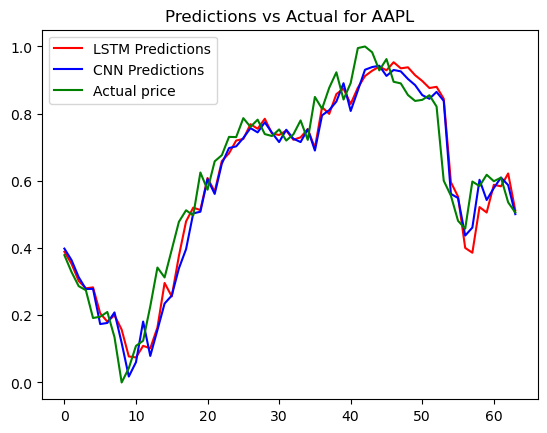

[*********************100%%**********************]  1 of 1 completed


2/2 [==============================] - 0s 3ms/step
[ 손실함수 ]
LSTM MSE: 0.004350413
CNN MSE: 0.004499871


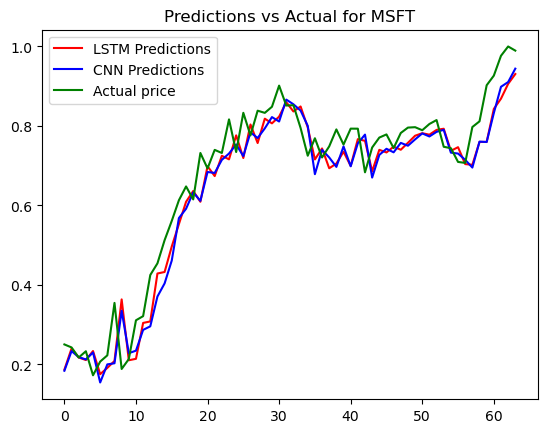

[*********************100%%**********************]  1 of 1 completed


2/2 [==============================] - 0s 2ms/step
[ 손실함수 ]
LSTM MSE: 0.0059163133
CNN MSE: 0.007022002


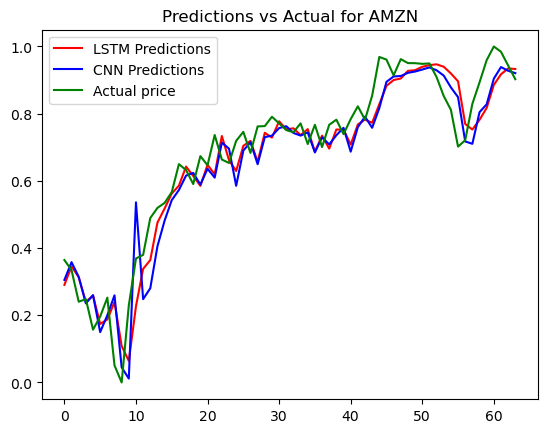

[*********************100%%**********************]  1 of 1 completed


2/2 [==============================] - 0s 2ms/step
[ 손실함수 ]
LSTM MSE: 0.014206741
CNN MSE: 0.014485499


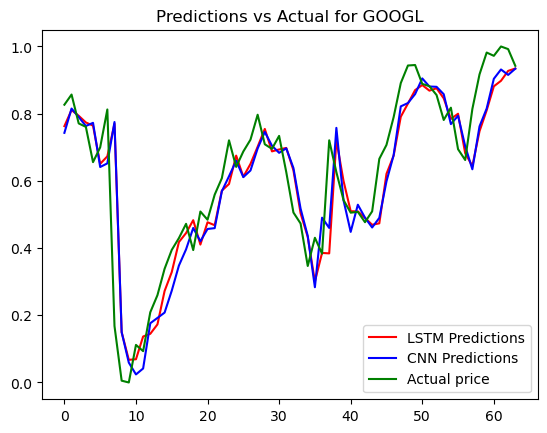

[*********************100%%**********************]  1 of 1 completed


2/2 [==============================] - 0s 2ms/step
[ 손실함수 ]
LSTM MSE: 0.011197148
CNN MSE: 0.011123652


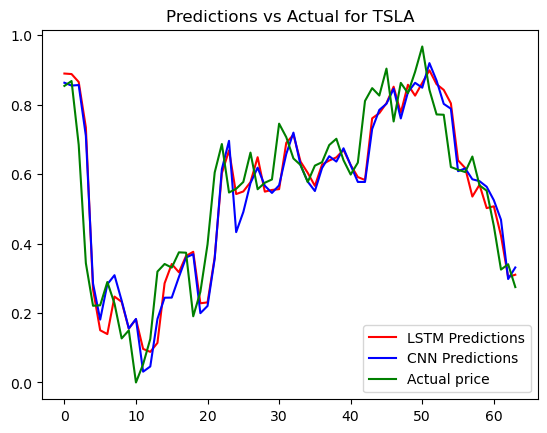

[ MSE Average ]
LSTM mse average : 0.011197147890925407
CNN mse average : 0.011123651638627052


In [58]:
from sklearn.metrics import mean_squared_error


# 두 모델을 최신데이터에 적용시켰을때 비교하는 함수
def others(symbol_list,start_date,end_date,n_steps,model1,model2,name1,name2):
    for i in symbol_list:
        # 전처리
        df = yfinance.download(i,start_date,end_date)
        df = df.drop(['Volume', 'Adj Close'], axis=1)
        # 정규화
        dataset, minmax = normalize_data(df)
        values = dataset.values
        # 데이터스플릿
        n_steps = n_steps
        new_X,new_y,new_n_features = data_setup(n_steps, values)
        
        # 예측하기
        pred_1 = model1.predict(new_X)
        pred_2 = model2.predict(new_X)
        
        # 평가
        model1_mse = []
        model2_mse = []
        
        print("[ 손실함수 ]")
        mse_1 = mean_squared_error(new_y, pred_1)
        model1_mse.append(mse_1)
        print(f"{name1} MSE:", mse_1)
        mse_2 = mean_squared_error(new_y, pred_2)
        model2_mse.append(mse_2)
        print(f"{name2} MSE:", mse_2)
        plt.plot(pred_1,'r', label= f'{name1} Predictions')  
        plt.plot(pred_2,'b', label = f'{name2} Predictions')
        plt.plot(new_y,'g', label = 'Actual price')
        plt.title(f"Predictions vs Actual for {i}")
        plt.legend()
        plt.show()
    
    model1_avr = sum(model1_mse) / len(model1_mse)
    model2_avr = sum(model2_mse) / len(model2_mse)
    print("[ MSE Average ]")
    print(f"{name1} mse average :", model1_avr)
    print(f"{name2} mse average :", model2_avr)

symbols = ['AAPL','MSFT','AMZN','GOOGL','TSLA']  
start_date = '2023-10-1'
end_date = '2024-1-18'
n_steps = 10
model1, m1 = LSTM_model, 'LSTM'
model2, m2 = CNN_model, 'CNN'
others(symbols,start_date,end_date,n_steps,model1,model2,m1,m2)

[*********************100%%**********************]  1 of 1 completed

< X > 
 [[[0.5408954  0.5219456  0.53832424 0.59421194]
  [0.5199995  0.43238482 0.43256077 0.48730043]
  [0.53373146 0.6903914  0.59477085 0.7229769 ]
  [0.78686523 0.7117438  0.7094475  0.6580041 ]
  [0.7379105  0.725979   0.79738545 0.773184  ]
  [0.7719399  0.7846981  0.8021389  0.85824025]
  [0.70686543 0.63641816 0.6684491  0.7088006 ]
  [0.7050745  0.7093717  0.6862746  0.79917353]
  [0.82507414 0.90391487 0.8722523  0.99114037]
  [1.         1.         0.95008934 1.        ]]

 [[0.5199995  0.43238482 0.43256077 0.48730043]
  [0.53373146 0.6903914  0.59477085 0.7229769 ]
  [0.78686523 0.7117438  0.7094475  0.6580041 ]
  [0.7379105  0.725979   0.79738545 0.773184  ]
  [0.7719399  0.7846981  0.8021389  0.85824025]
  [0.70686543 0.63641816 0.6684491  0.7088006 ]
  [0.7050745  0.7093717  0.6862746  0.79917353]
  [0.82507414 0.90391487 0.8722523  0.99114037]
  [1.         1.         0.95008934 1.        ]
  [0.9707459  0.9276393  1.         0.96810436]]] (21, 10, 4)
< y > 
 [[0.9707


/var/folders/69/0x25zsbs24x5sj1x4z6z0sth0000gn/T/ipykernel_3531/2640914283.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df2 = df2.drop(['Volume'],1).drop(['Adj Close'],1)
/var/folders/69/0x25zsbs24x5sj1x4z6z0sth0000gn/T/ipykernel_3531/2640914283.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df2 = df2.drop(['Volume'],1).drop(['Adj Close'],1)


[ 손실함수 ]
LSTM MSE: 0.013967926
CNN MSE: 0.018446127


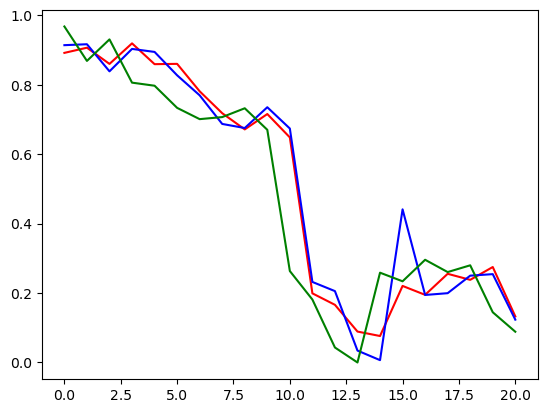

In [15]:
from sklearn.metrics import mean_squared_error

df2 = yfinance.download('AAPL','2023-12-1','2024-1-18')
df2 = df2.drop(['Volume'],1).drop(['Adj Close'],1)
#display("< original dataset >", df2.tail(10))

# 정규화
dataset2, minmax2 = normalize_data(df2)
values2 = dataset2.values
#display("< nomalized dataset >", dataset2.head(21),dataset2.shape)
# 종가 예측은 11번째부터 시작 (12.15일부터)

# 데이터 전처리
n_steps = 10   # 10일분량씩 쪼개어, 인풋데이터를 만듦
new_X,new_y,new_n_features = data_setup(n_steps, values2)
# display("new_X", new_X[:3], new_X.shape)
# display("new_y", new_y, new_y.shape)

# 예측하기
lstm_pred_Apple = LSTM_model.predict(new_X)
cnn_pred_Apple = CNN_model.predict(new_X)


# 정규화 예측값 시각화

print("[ 손실함수 ]")
LSTM_mse = mean_squared_error(new_y, lstm_pred_Apple)
print("LSTM MSE:", LSTM_mse)
CNN_mse = mean_squared_error(new_y, cnn_pred_Apple)
print("CNN MSE:", CNN_mse)
plt.plot(lstm_pred_Apple,'r')  # 예측 종가값(정규화된 값)
plt.plot(cnn_pred_Apple,'b')  # 예측 종가값(정규화된 값)
plt.plot(new_y,'g')     # 실제 종가값(정규화된 값)

# 1. 단순평균 앙상블

# 평가 MSE

In [5]:
from sklearn.metrics import mean_squared_error


# 두 모델의 예측 결과 계산
lstm_predictions = LSTM_model.predict(X_test)
cnn_predictions = CNN_model.predict(X_test)

# 단순 평균 앙상블
ensemble_predictions = (lstm_predictions + cnn_predictions) / 2

# 성능 평가
# 예를 들어, 실제 값에 대한 MSE 계산
ensemble_mse = mean_squared_error(y_test, ensemble_predictions)
print("Ensemble MSE:", ensemble_mse)



16/16 [==============================] - 0s 2ms/step
Ensemble MSE: 6.499393e-07


In [7]:
print(CNN_model.evaluate(X_test,y_test))
CNN_mse = mean_squared_error(y_test, cnn_predictions)
print("CNN MSE:", CNN_mse)
LSTM_mse = mean_squared_error(y_test, lstm_predictions)
print("LSTM MSE:", LSTM_mse)

16/16 [==============================] - 0s 3ms/step - loss: 5.5588e-07
5.558787279369426e-07
CNN MSE: 5.558787e-07
LSTM MSE: 1.060384e-06


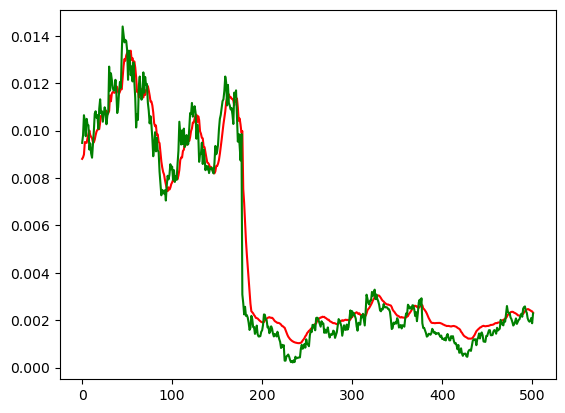

In [9]:
from matplotlib import pyplot as plt
pred_test = ensemble_predictions
plt.plot(pred_test,'r') 
plt.plot(y_test,'g')     

# 2. 가중평균 앙상블
- 가중치는 모델의 성능이나 중요도에 따라 조정. 실험을 통해 가장 좋은 성능을 내는 가중치 조합을 찾는 것이 중요.
- 0.5 : 0.5로하면 그냥 단순평균앙상블과 같아진다.
- 결과 : test셋에서는 cnn쪽으로 가중치를 올렸을때 가장성능이 좋앗지만, 최신주가데이터에 반영할떈 LSTM으로 가중치를높일수록 가장좋았다.
- 최신데이터[가중평균] Ensemble MSE: 0.013915343

In [27]:
# Model load
LSTM_model = load_keras_model(optimizer,loss, lstm_dirx, lstm_json, lstm_h5)
CNN_model = load_keras_model(optimizer,loss, CNN_dirx, CNN_json, CNN_h5)

# 두 모델의 예측 결과 계산
lstm_predictions = LSTM_model.predict(X_test)
cnn_predictions = CNN_model.predict(X_test)

# 가중치 설정 
weight_lstm = 0.3
weight_cnn = 0.7

# 가중평균 앙상블 예측
ensemble_predictions = (lstm_predictions * weight_lstm) + (cnn_predictions * weight_cnn)

# 성능 평가 (예: 가중평균앙상블)
mse = mean_squared_error(y_test, ensemble_predictions)
print("가중평균 Ensemble MSE:", mse)


 7/16 [============>.................] - ETA: 0s

2024-01-23 14:46:56.074802: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 0s 3ms/step
가중평균 Ensemble MSE: 5.74349e-07


2024-01-23 14:46:56.511172: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


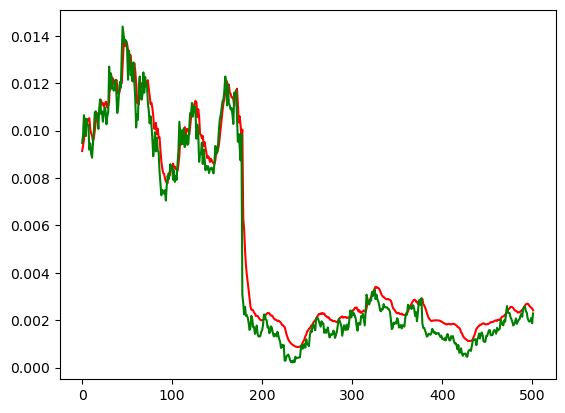

In [14]:
# 가중평균 앙상블 결과
from matplotlib import pyplot as plt
pred_test = ensemble_predictions
plt.plot(pred_test,'r') 
plt.plot(y_test,'g')   

# 최신주가데이터 적용

[*********************100%%**********************]  1 of 1 completed

< X > 
 [[[0.5408954  0.5219456  0.53832424 0.59421194]
  [0.5199995  0.43238482 0.43256077 0.48730043]
  [0.53373146 0.6903914  0.59477085 0.7229769 ]
  [0.78686523 0.7117438  0.7094475  0.6580041 ]
  [0.7379105  0.725979   0.79738545 0.773184  ]
  [0.7719399  0.7846981  0.8021389  0.85824025]
  [0.70686543 0.63641816 0.6684491  0.7088006 ]
  [0.7050745  0.7093717  0.6862746  0.79917353]
  [0.82507414 0.90391487 0.8722523  0.99114037]
  [1.         1.         0.95008934 1.        ]]

 [[0.5199995  0.43238482 0.43256077 0.48730043]
  [0.53373146 0.6903914  0.59477085 0.7229769 ]
  [0.78686523 0.7117438  0.7094475  0.6580041 ]
  [0.7379105  0.725979   0.79738545 0.773184  ]
  [0.7719399  0.7846981  0.8021389  0.85824025]
  [0.70686543 0.63641816 0.6684491  0.7088006 ]
  [0.7050745  0.7093717  0.6862746  0.79917353]
  [0.82507414 0.90391487 0.8722523  0.99114037]
  [1.         1.         0.95008934 1.        ]
  [0.9707459  0.9276393  1.         0.96810436]]] (21, 10, 4)
< y > 
 [[0.9707


/var/folders/69/0x25zsbs24x5sj1x4z6z0sth0000gn/T/ipykernel_3531/3757490755.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df2 = df2.drop(['Volume'],1).drop(['Adj Close'],1)
/var/folders/69/0x25zsbs24x5sj1x4z6z0sth0000gn/T/ipykernel_3531/3757490755.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df2 = df2.drop(['Volume'],1).drop(['Adj Close'],1)


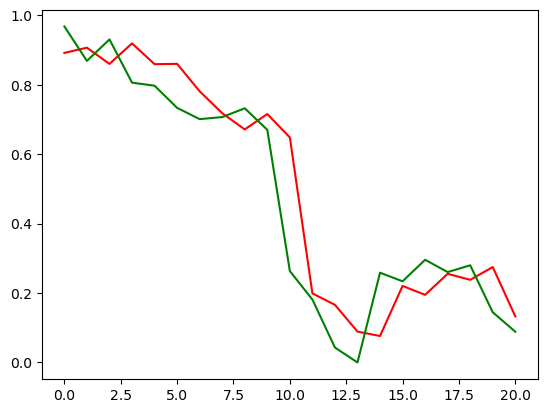

In [37]:
from sklearn.metrics import mean_squared_error

# 데이터 수집
df2 = yfinance.download('AAPL','2023-10-1','2024-1-18')
df2 = df2.drop(['Volume'],1).drop(['Adj Close'],1)
#display("< original dataset >", df2.tail(10))

# 정규화
dataset2, minmax2 = normalize_data(df2)
values2 = dataset2.values
#display("< nomalized dataset >", dataset2.head(21),dataset2.shape)
# 종가 예측은 11번째부터 시작 (12.15일부터)

# 데이터 전처리
n_steps = 10   # 10일분량씩 쪼개어, 인풋데이터를 만듦
new_X,new_y,new_n_features = data_setup(n_steps, values2)
# display("new_X", new_X[:3], new_X.shape)
# display("new_y", new_y, new_y.shape)

# 예측하기
lstm_pred_Apple = LSTM_model.predict(new_X)
cnn_pred_Apple = CNN_model.predict(new_X)

# 가중치 설정 
weight_lstm = 1
weight_cnn = 0

# 가중평균 앙상블 예측
ensemble_predictions = (lstm_pred_Apple * weight_lstm) + (cnn_pred_Apple * weight_cnn)

# 성능 평가 (예: 가중평균앙상블)
mse = mean_squared_error(new_y, ensemble_predictions)
print("[가중평균] Ensemble MSE:", mse)

# 정규화 예측값 시각화

plt.plot(ensemble_predictions,'r') 
plt.plot(new_y,'g')     